In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
sns.set()
tf.compat.v1.random.set_random_seed(1234)

from preprocess import download_csv, process_csv, process_csv_locations, interpolate_cases

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# url = "https://data.ontario.ca/dataset/f4112442-bdc8-45d2-be3c-12efae72fb27/resource/455fd63b-603d-4608-8216-7d8647f43350/download/conposcovidloc.csv"
# save_location = os.path.join(os.getcwd(), "../data/conposcovidloc.csv")
# download_csv(url, save_location)

ontario = process_csv('../data/conposcovidloc.csv')
locations_dict = process_csv_locations('../data/conposcovidloc.csv')
pd_locations_dict = {}

# For Cities Within Ontario
for key in locations_dict.keys():
    inter_dates, inter_cases = interpolate_cases(locations_dict[key][0][-200:], locations_dict[key][1][-200:], start=str(ontario[0][-199]), end='2021-02-04')
    pd_locations_dict[key] = pd.DataFrame({'Date': inter_dates, 'Count': inter_cases})

# For all of Ontario
inter_dates, inter_cases = interpolate_cases(ontario[0][-200:], ontario[1][-200:], start=str(ontario[0][-199]), end='2021-02-04')
pd_locations_dict['Ontario'] = pd.DataFrame({'Date': inter_dates, 'Count': inter_cases})
locations_dict['Ontario'] = ontario

locations_list = [loc for loc in locations_dict.keys()]

In [3]:
minmax = {}
df_log = {}

for key in locations_dict.keys():
    minmax[key] = MinMaxScaler().fit(pd_locations_dict[key].iloc[:, 1:2].astype('float32'))
    df_log[key] = minmax[key].transform(pd_locations_dict[key].iloc[:, 1:2].astype('float32'))
    df_log[key] = pd.DataFrame(df_log[key])

In [4]:
test_size = 7  # 7 Days
simulation_size = 10

num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.001

df_train = {}
for key in locations_dict.keys():
    df_train[key] = df_log[key]

In [53]:
pd_locations_dict['Ontario'].shape, df_train['Ontario'].shape

((198, 2), (198, 1))

In [5]:
def layer_norm(inputs, epsilon=1e-8):
    mean, variance = tf.nn.moments(inputs, [-1], keep_dims=True)
    normalized = (inputs - mean) / (tf.sqrt(variance + epsilon))

    params_shape = inputs.get_shape()[-1:]
    gamma = tf.get_variable('gamma', params_shape, tf.float32, tf.ones_initializer())
    beta = tf.get_variable('beta', params_shape, tf.float32, tf.zeros_initializer())
    
    outputs = gamma * normalized + beta
    return outputs

def multihead_attn(queries, keys, q_masks, k_masks, future_binding, num_units, num_heads):
    
    T_q = tf.shape(queries)[1]                                      
    T_k = tf.shape(keys)[1]                  

    Q = tf.layers.dense(queries, num_units, name='Q')                              
    K_V = tf.layers.dense(keys, 2*num_units, name='K_V')    
    K, V = tf.split(K_V, 2, -1)        

    Q_ = tf.concat(tf.split(Q, num_heads, axis=2), axis=0)                         
    K_ = tf.concat(tf.split(K, num_heads, axis=2), axis=0)                    
    V_ = tf.concat(tf.split(V, num_heads, axis=2), axis=0)                      

    align = tf.matmul(Q_, tf.transpose(K_, [0,2,1]))                      
    align = align / np.sqrt(K_.get_shape().as_list()[-1])                 

    paddings = tf.fill(tf.shape(align), float('-inf'))                   

    key_masks = k_masks                                                 
    key_masks = tf.tile(key_masks, [num_heads, 1])                       
    key_masks = tf.tile(tf.expand_dims(key_masks, 1), [1, T_q, 1])            
    align = tf.where(tf.equal(key_masks, 0), paddings, align)       

    if future_binding:
        lower_tri = tf.ones([T_q, T_k])                                          
        lower_tri = tf.linalg.LinearOperatorLowerTriangular(lower_tri).to_dense()  
        masks = tf.tile(tf.expand_dims(lower_tri,0), [tf.shape(align)[0], 1, 1]) 
        align = tf.where(tf.equal(masks, 0), paddings, align)                      
    
    align = tf.nn.softmax(align)                                            
    query_masks = tf.to_float(q_masks)                                             
    query_masks = tf.tile(query_masks, [num_heads, 1])                             
    query_masks = tf.tile(tf.expand_dims(query_masks, -1), [1, 1, T_k])            
    align *= query_masks
    
    outputs = tf.matmul(align, V_)                                                 
    outputs = tf.concat(tf.split(outputs, num_heads, axis=0), axis=2)             
    outputs += queries                                                             
    outputs = layer_norm(outputs)                                                 
    return outputs


def pointwise_feedforward(inputs, hidden_units, activation=None):
    outputs = tf.layers.dense(inputs, 4*hidden_units, activation=activation)
    outputs = tf.layers.dense(outputs, hidden_units, activation=None)
    outputs += inputs
    outputs = layer_norm(outputs)
    return outputs


def learned_position_encoding(inputs, mask, embed_dim):
    T = tf.shape(inputs)[1]
    outputs = tf.range(tf.shape(inputs)[1])                # (T_q)
    outputs = tf.expand_dims(outputs, 0)                   # (1, T_q)
    outputs = tf.tile(outputs, [tf.shape(inputs)[0], 1])   # (N, T_q)
    outputs = embed_seq(outputs, T, embed_dim, zero_pad=False, scale=False)
    return tf.expand_dims(tf.to_float(mask), -1) * outputs


def sinusoidal_position_encoding(inputs, mask, repr_dim):
    T = tf.shape(inputs)[1]
    pos = tf.reshape(tf.range(0.0, tf.to_float(T), dtype=tf.float32), [-1, 1])
    i = np.arange(0, repr_dim, 2, np.float32)
    denom = np.reshape(np.power(10000.0, i / repr_dim), [1, -1])
    enc = tf.expand_dims(tf.concat([tf.sin(pos / denom), tf.cos(pos / denom)], 1), 0)
    return tf.tile(enc, [tf.shape(inputs)[0], 1, 1]) * tf.expand_dims(tf.to_float(mask), -1)

def label_smoothing(inputs, epsilon=0.1):
    C = inputs.get_shape().as_list()[-1]
    return ((1 - epsilon) * inputs) + (epsilon / C)

class Attention:
    def __init__(self, size_layer, embedded_size, learning_rate, size, output_size,
                 num_blocks = 2,
                 num_heads = 8,
                 min_freq = 50):
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        
        encoder_embedded = tf.layers.dense(self.X, embedded_size)
        encoder_embedded = tf.nn.dropout(encoder_embedded, keep_prob = 0.8)
        x_mean = tf.reduce_mean(self.X, axis = 2)
        en_masks = tf.sign(x_mean)
        encoder_embedded += sinusoidal_position_encoding(self.X, en_masks, embedded_size)
        
        for i in range(num_blocks):
            with tf.variable_scope('encoder_self_attn_%d'%i,reuse=tf.AUTO_REUSE):
                encoder_embedded = multihead_attn(queries = encoder_embedded,
                                             keys = encoder_embedded,
                                             q_masks = en_masks,
                                             k_masks = en_masks,
                                             future_binding = False,
                                             num_units = size_layer,
                                             num_heads = num_heads)

            with tf.variable_scope('encoder_feedforward_%d'%i,reuse=tf.AUTO_REUSE):
                encoder_embedded = pointwise_feedforward(encoder_embedded,
                                                    embedded_size,
                                                    activation = tf.nn.relu)
                
        self.logits = tf.layers.dense(encoder_embedded[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
        
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [7]:
def forecast(minmax, df, df_log, df_train):
    tf.reset_default_graph()
    modelnn = Attention(size_layer, size_layer, learning_rate, df_log.shape[1], df_log.shape[1])
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, _, loss = sess.run(
                [modelnn.logits, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y
                },
            ) 
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
    
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits = sess.run(
            modelnn.logits,
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                )
            },
        )
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits = sess.run(
            modelnn.logits,
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0)
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits = sess.run(
            modelnn.logits,
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0)
            },
        )
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    return deep_future

In [8]:
#locations_list[:len(locations_list)//2]
#locations_list[len(locations_list)//2:-1]

In [9]:
results = {}
for key in locations_list[:1]:
    print("LOCATION: " + key)
    results[key] = []
    for i in range(simulation_size):
        print('simulation %d'%(i + 1))
        results[key].append(forecast(minmax[key], pd_locations_dict[key], df_log[key], df_train[key]))
    print(3*'\n')

LOCATION: Oakville
simulation 1
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use `tf.cast` instead.
train loop: 100%|██████████| 300/300 [00:33<00:00,  9.05it/s, acc=94.7, cost=0.00837]
simulation 2
train loop: 100%|██████████| 300/300 [00:33<00:00,  8.98it/s, acc=96.1, cost=0.00366]
simulation 3
train loop: 100%|██████████| 300/300 [00:32<00:00,  9.10it/s, acc=96.3, cost=0.00314]
simulation 4
train loop: 100%|██████████| 300/300 [00:31<00:00,  9.49it/s, acc=94.7, cost=0.00756]
simulation 5
train loop: 100%|██████████| 300/300 [00:33<00:00,  8.86it/s, acc=95.7, cost=0.00467]
simulation 6
train loop: 100%|██████████| 300/300 [00:32<00:00,  9.25it/s, acc=96.8, cost=0.00277]
simulation 7
train loop: 100%|██████████| 300/300 [00:33<00:00,  8.92it/s, acc=95.6, cost=0.00478]
simulation 8
train loop: 100%|██████████| 300/300 [00:32<00:00,  9.12it/s, acc=96.4, cost=0.00309]
simulation 9
train loop:

In [10]:
key = "Ontario"
print("LOCATION: " + key)
results[key] = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results[key].append(forecast(minmax[key], pd_locations_dict[key], df_log[key], df_train[key]))
print(3*'\n')

LOCATION: Ontario
simulation 1
train loop: 100%|██████████| 300/300 [00:34<00:00,  8.58it/s, acc=96, cost=0.00468]
simulation 2
train loop: 100%|██████████| 300/300 [00:32<00:00,  9.27it/s, acc=97.2, cost=0.00205]
simulation 3
train loop: 100%|██████████| 300/300 [00:34<00:00,  8.57it/s, acc=97.9, cost=0.00109]
simulation 4
train loop: 100%|██████████| 300/300 [00:34<00:00,  8.70it/s, acc=97.5, cost=0.00235]
simulation 5
train loop: 100%|██████████| 300/300 [00:34<00:00,  8.65it/s, acc=97.4, cost=0.00302]
simulation 6
train loop: 100%|██████████| 300/300 [00:34<00:00,  8.78it/s, acc=96.9, cost=0.00237]
simulation 7
train loop: 100%|██████████| 300/300 [00:34<00:00,  8.71it/s, acc=96.5, cost=0.0029]
simulation 8
train loop: 100%|██████████| 300/300 [00:34<00:00,  8.66it/s, acc=97.3, cost=0.00234]
simulation 9
train loop: 100%|██████████| 300/300 [00:34<00:00,  8.69it/s, acc=97.4, cost=0.0019]
simulation 10
train loop: 100%|██████████| 300/300 [00:34<00:00,  8.73it/s, acc=97.2, cost=0.00

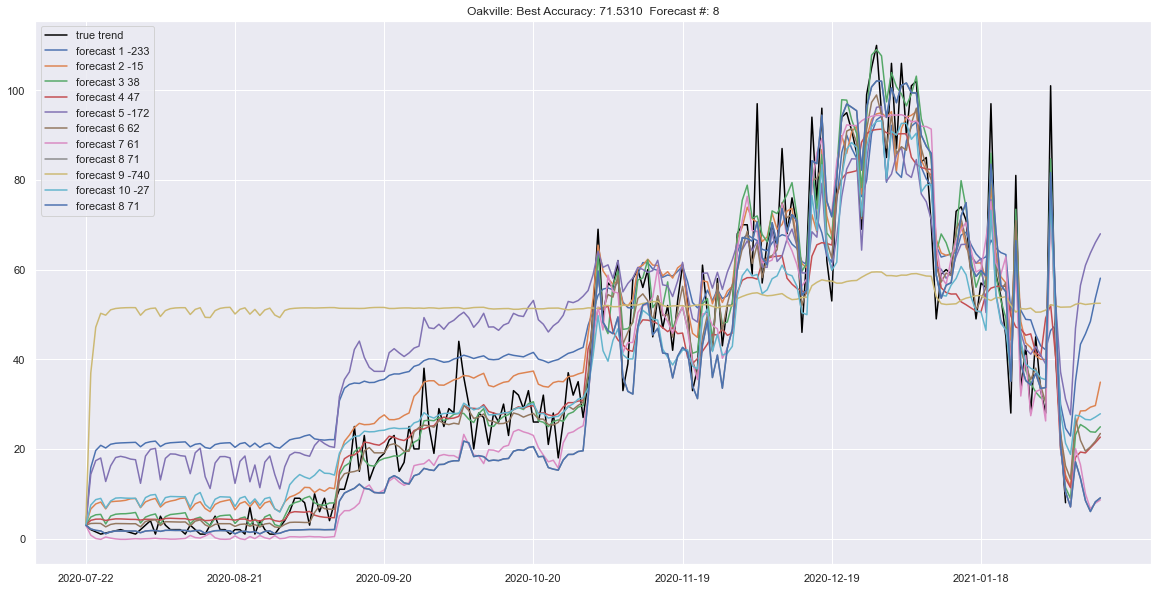

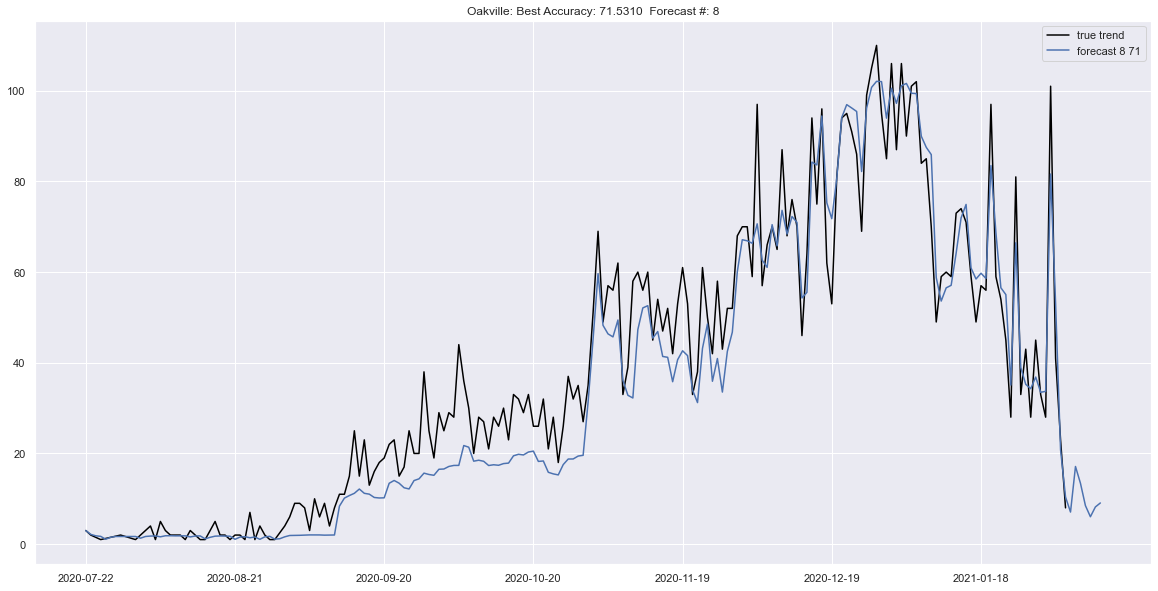

In [42]:
accuracies = {}
max_acc = {}

# for key in locations_dict.keys():
#     accuracies[key] = [calculate_accuracy(pd_locations_dict[key]['Count'].iloc[-test_size:].values, r) for r in results[key]]
#     max_acc[key] = accuracies[key].index(max(accuracies[key]))

#     plt.figure(figsize = (20, 10))
#     plt.plot(pd_locations_dict[key]['Count'][-200:], label = 'true trend', c = 'black')

#     x_range_future = np.arange(len(results[key][0]))
#     plt.xticks(x_range_future[::30], pd_locations_dict[key][0][-200:][::30])

#     plt.legend()
#     plt.title(key + ': Best Accuracy: %.4f '%(np.mean(accuracies[max_acc])) + " Forecast #: " + str(max_acc+1))
#     plt.show()

key = 'Oakville'

accuracies[key] = [calculate_accuracy(pd_locations_dict[key]['Count'].values, r[:-test_size]) for r in results[key]]
max_acc[key] = accuracies[key].index(max(accuracies[key]))

plt.figure(figsize = (20, 10))
plt.plot(pd_locations_dict[key]['Count'][-200:], label = 'true trend', c = 'black')

for no, r in enumerate(results[key]):
    plt.plot(r, label = 'forecast %d %d' % ((no + 1), accuracies[key][no]))

plt.plot(results[key][max_acc[key]], label = 'forecast %d %d' % ((max_acc[key] + 1), accuracies[key][max_acc[key]]))

x_range_future = np.arange(len(results[key][0]))
plt.xticks(x_range_future[::30], pd_locations_dict[key]['Date'][-200:][::30])

plt.legend()
plt.title(key + ': Best Accuracy: %.4f '%(np.mean(accuracies[key][max_acc[key]])) + " Forecast #: " + str(max_acc[key]+1))
plt.show()

#-----------------------------------------

plt.figure(figsize = (20, 10))
plt.plot(pd_locations_dict[key]['Count'][-200:], label = 'true trend', c = 'black')

plt.plot(results[key][max_acc[key]], label = 'forecast %d %d' % ((max_acc[key] + 1), accuracies[key][max_acc[key]]))

x_range_future = np.arange(len(results[key][0]))
plt.xticks(x_range_future[::30], pd_locations_dict[key]['Date'][-200:][::30])

plt.legend()
plt.title(key + ': Best Accuracy: %.4f '%(np.mean(accuracies[key][max_acc[key]])) + " Forecast #: " + str(max_acc[key]+1))
plt.show()

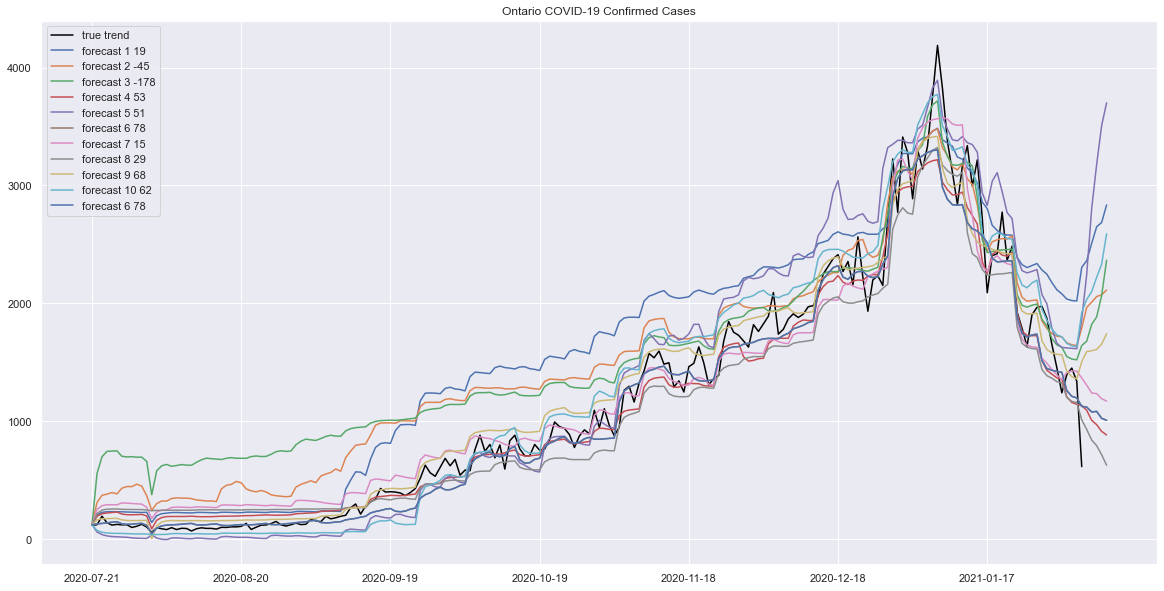

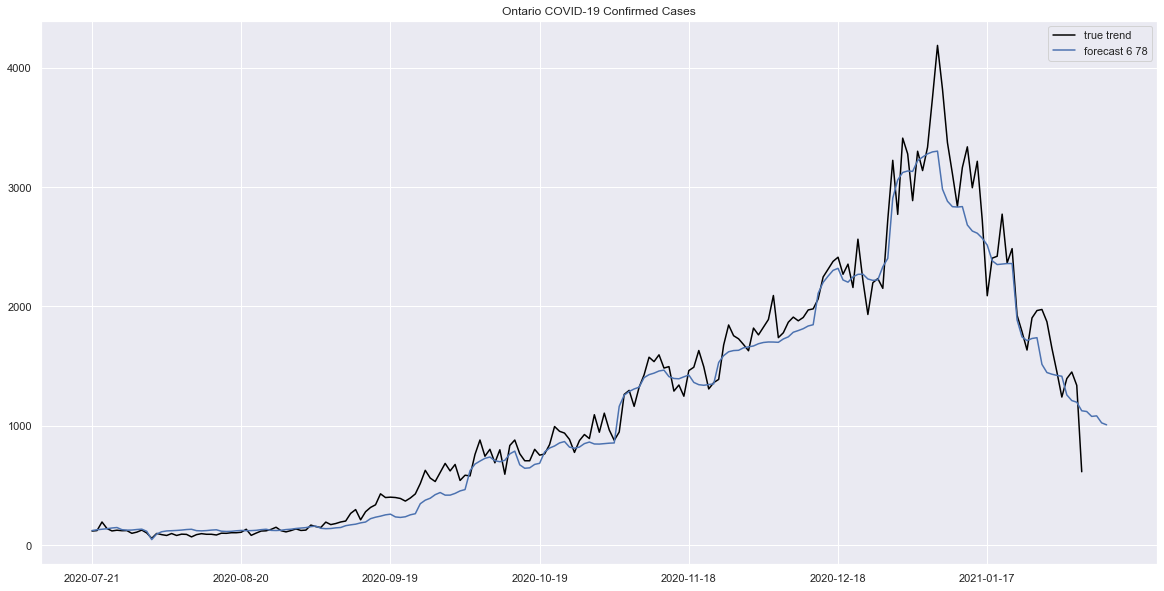

In [43]:
accuracies['Ontario'] = [calculate_accuracy(pd_locations_dict['Ontario']['Count'].values, r[:-test_size]) for r in results['Ontario']]
max_acc['Ontario'] = accuracies['Ontario'].index(max(accuracies['Ontario']))

plt.figure(figsize = (20, 10))
plt.plot(ontario[1][-200:], label = 'true trend', c = 'black')

for no, r in enumerate(results['Ontario']):
    plt.plot(r, label = 'forecast %d %d' % ((no + 1), accuracies['Ontario'][no]))

plt.plot(results['Ontario'][max_acc['Ontario']], label = 'forecast %d %d' % ((max_acc['Ontario'] + 1), accuracies['Ontario'][max_acc['Ontario']]))

x_range_future = np.arange(len(results['Ontario'][0]))
plt.xticks(x_range_future[::30], ontario[0][-200:][::30])

plt.legend()
plt.title("Ontario COVID-19 Confirmed Cases")
plt.show()

#-----------------------------------------

plt.figure(figsize = (20, 10))
plt.plot(ontario[1][-200:], label = 'true trend', c = 'black')

plt.plot(results['Ontario'][max_acc['Ontario']], label = 'forecast %d %d' % ((max_acc['Ontario'] + 1), accuracies['Ontario'][max_acc['Ontario']]))

x_range_future = np.arange(len(results['Ontario'][0]))
plt.xticks(x_range_future[::30], ontario[0][-200:][::30])

plt.legend()
plt.title("Ontario COVID-19 Confirmed Cases")
plt.show()